# Generating FBM Samples wrt Time, using FBM library

* We can observe that increasing hurst parameter, we get smoother relaisations of motion.

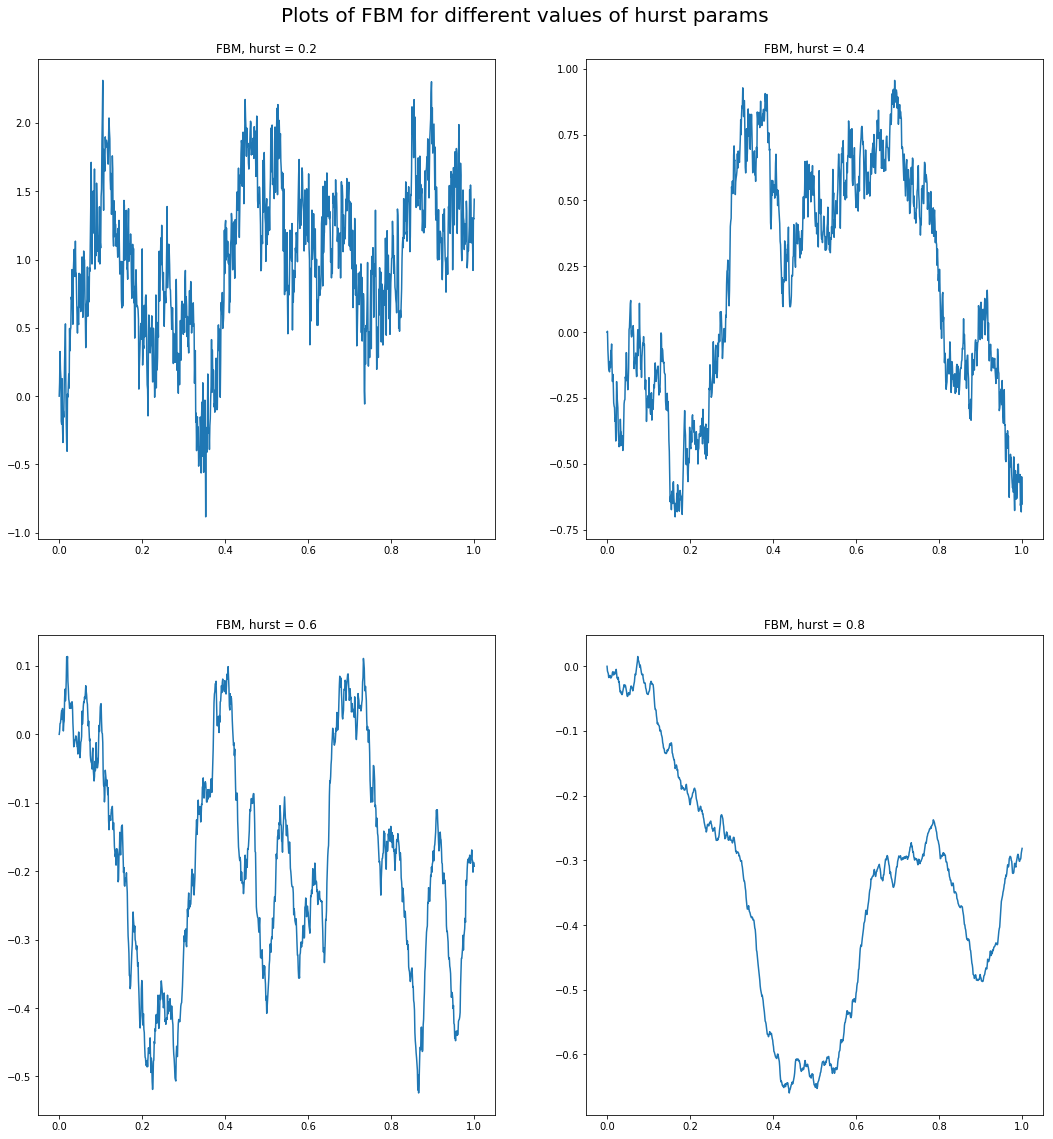

In [1]:
%matplotlib inline

from fbm import FBM
import matplotlib.pyplot as plt
import numpy as np

from scipy.fftpack import fft, ifft, fftfreq

def plt_fbm(h_param,num_samp,subplot_index=111):
    f = FBM(n=num_samp, hurst=h_param, length=1, method='cholesky')
    # Generate a fBm realization
    fbm_sample = f.fbm()

    # Get the times associated with the fBm
    t_values = f.times()
    
    ax= fig.add_subplot(subplot_index)
    ax.set_title("FBM, hurst = "+str(h_param))
    ax.plot(t_values,fbm_sample)
    #print(t_values)
    return fbm_sample

plt.rcParams['figure.figsize'] = (18, 18)
fig = plt.figure()
fig.tight_layout()
fig.subplots_adjust(top=0.94)
fbm_samps=[]
plt.suptitle("Plots of FBM for different values of hurst params",fontsize=20)
num_pts=1000
t_samp=np.linspace(0,1,num_pts+1)
fbm_samps.append(plt_fbm(0.2,num_pts,221))
fbm_samps.append(plt_fbm(0.4,num_pts,222))
fbm_samps.append(plt_fbm(0.6,num_pts,223))
fbm_samps.append(plt_fbm(0.8,num_pts,224))
plt.show()

# Plotting the FFT of FBM motion as well

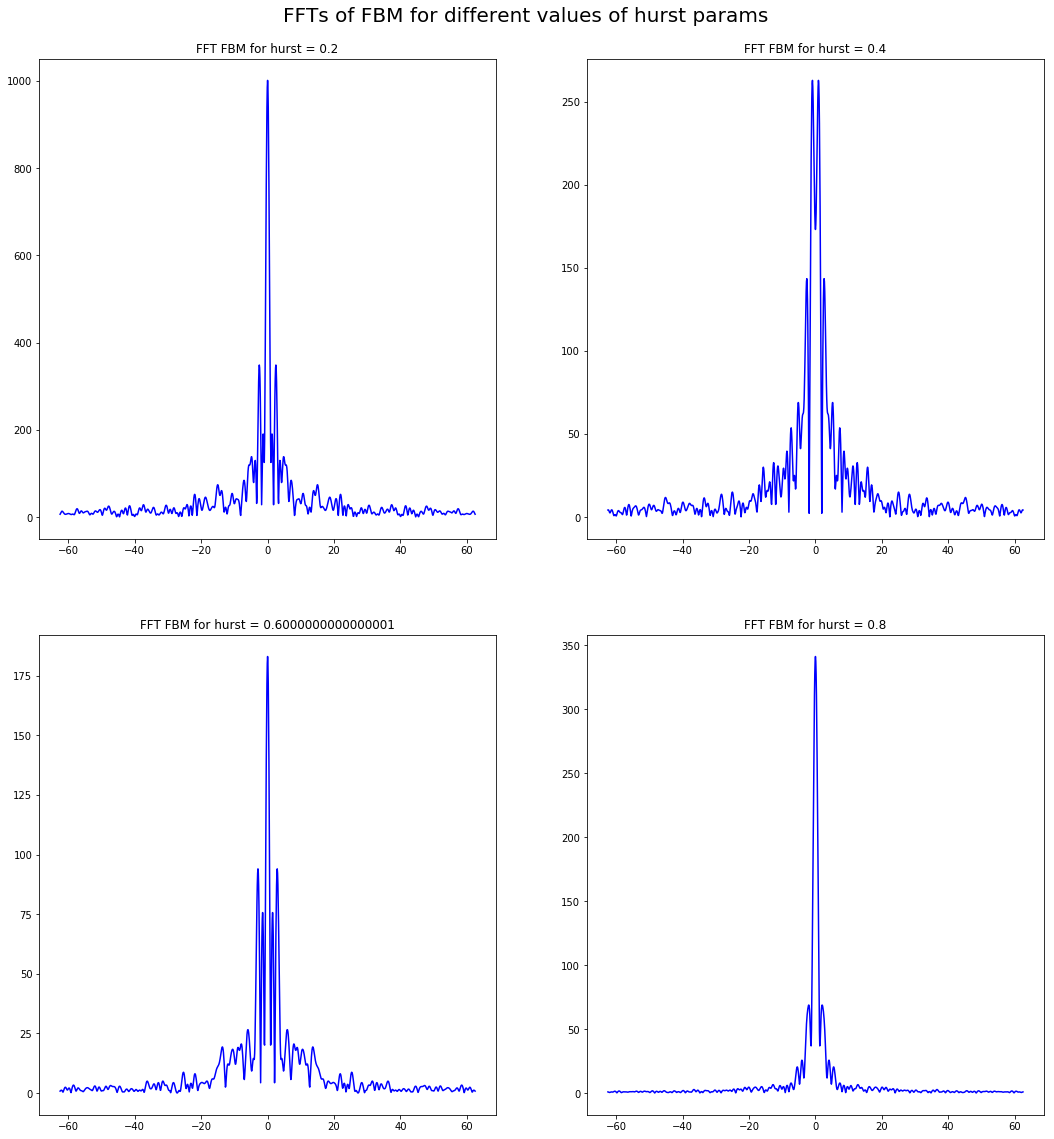

In [2]:
def plot_fft(fbm_vals,hurst,subplot_index=111):
    samp_freq=1000
    NFFT=10*t_samp.shape[0]
    zp_arr=np.append(np.array(fbm_vals),np.zeros(NFFT-len(fbm_vals)))
    fbm_freq=np.fft.fftshift(fft(zp_arr,NFFT))
    disc_w=np.linspace(-samp_freq/16,samp_freq/16,NFFT//8)
    ax= fig.add_subplot(subplot_index)
    ax.set_title("FFT FBM for hurst = "+str(hurst))
    ax.plot(disc_w,abs(fbm_freq[NFFT//2-NFFT//16:NFFT//2+NFFT//16+1]),'b')
    return fbm_freq[0:NFFT//2]

plt.rcParams['figure.figsize'] = (18, 18)
fig = plt.figure()
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.suptitle("FFTs of FBM for different values of hurst params",fontsize=20)
subplot_list=[221,222,223,224]
freq_fbm_samps=[]
for i in range(len(fbm_samps)): 
    freq_fbm_samps.append(plot_fft(fbm_samps[i],0.2*(i+1),subplot_list[i]))
plt.show()


# PCA spectrum of single FBM signals


0.448909754337


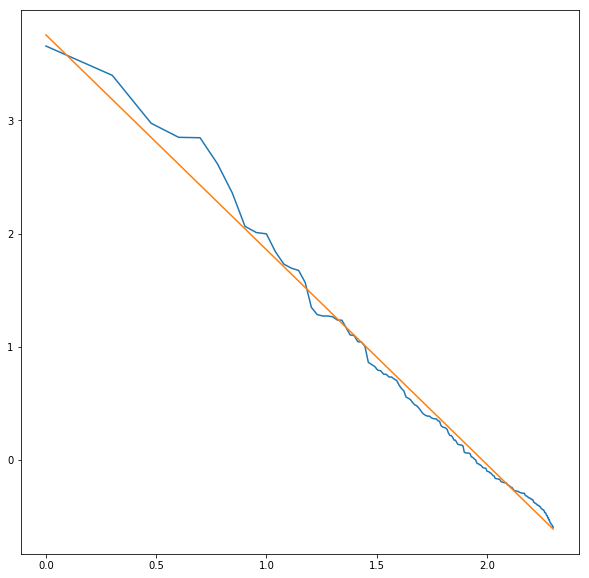

In [3]:
from scipy.ndimage.interpolation import shift
from scipy.linalg import toeplitz,inv,svd
from scipy.optimize import curve_fit

def Lf(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

M=200
H=0.6
f = FBM(n=M, hurst=H, length=0.5, method='daviesharte')
# Generate a fBm realization
fbm_sample = f.fbm()
# Get the times associated with the fBm
t_values = f.times()
#print(t_values)
# plt.plot(t_values,fbm_sample)
# plt.show()

R=np.zeros(M+1) #Autocorrelation: r[0] to r[p-1]

for k in range(M+1):
    fbm_shift=shift(fbm_sample, k, cval=0)
    R[k]=np.sum(fbm_sample*np.conjugate(fbm_shift))

AutoCorr_mat=toeplitz(R[0:M],R[0:M])

num_sim=50
for i in range(num_sim):
    f1 = FBM(n=M, hurst=H, length=0.5, method='daviesharte')
    # Generate a fBm realization
    if(i==0):
        avg_sample=f1.fgn()
    else:
        avg_sample += f1.fgn()

#mean_vec=[t_values[i]**(2*H) for i in range(0,M)]
mean_vec=avg_sample/num_sim
#print(mean_vec)
AutoCov_mat=AutoCorr_mat

U,S,V=svd(AutoCov_mat)
plt.rcParams['figure.figsize'] = (10, 10)
plt.plot(np.log10(np.arange(M)+1),np.log10(S))

expected_slope=-(2*H+1)
A,B = curve_fit(Lf,np.log10(np.arange(M)+1),np.log10(S))[0] # your data x, y to fit
print(-(A+1)/2)
plt.plot([0,np.log10(M)],[B,A*np.log10(M)+B])
plt.show()

#print(S)


513
[[ -1.07027048e-04  -7.52560412e-05   4.90351148e-05 ...,  -1.06207751e-05
    4.78553500e-05   0.00000000e+00]
 [ -7.52560412e-05  -5.29162659e-05   3.44790283e-05 ...,  -7.46799527e-06
    3.36494770e-05   0.00000000e+00]
 [  4.90351148e-05   3.44790283e-05  -2.24657460e-05 ...,   4.86597486e-06
   -2.19252294e-05   0.00000000e+00]
 ..., 
 [ -1.06207751e-05  -7.46799527e-06   4.86597486e-06 ...,  -1.05394726e-06
    4.74890150e-06   0.00000000e+00]
 [  4.78553500e-05   3.36494770e-05  -2.19252294e-05 ...,   4.74890150e-06
   -2.13977173e-05   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


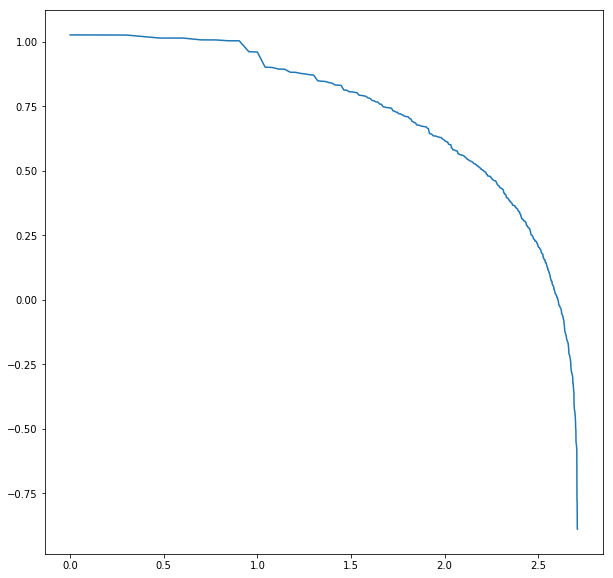

In [4]:
import pywt

def Qf(x, A, B,C): # this is your 'straight line' y=f(x)
    return A*x**2 + B*x + C

def get_wavelet_var(wavelet,H=0.3,est_sil=1):
    samp_size=1024
    f = FBM(n=samp_size, hurst=H, length=0.5, method='daviesharte')
    # Generate a fBm realization
    fbm_sample = f.fbm()
    # Get the times associated with the fBm
    t_values = f.times()
    cA, cD = pywt.dwt(fbm_sample, wavelet)
    
    M=len(cD)
    print(M)
    # plt.rcParams['figure.figsize'] = (10, 10)
    # #plt.plot(fbm_sample[::2])
    # #plt.plot(cD)
    # plt.show()
    R=np.zeros(M+1) #Autocorrelation: r[0] to r[p-1]

    for k in range(M+1):
        cD_shift=shift(cD, k, cval=0)
        R[k]=np.sum(cD*np.conjugate(cD_shift))

    AutoCorr_mat=toeplitz(R[0:M],R[0:M])

    num_sim=50
    for i in range(num_sim):
        f1 = FBM(n=samp_size, hurst=H, length=0.5, method='daviesharte')
        # Generate a fBm realization
        if(i==0):
            temp_cA,temp_cD=pywt.dwt(f1.fbm(),wavelet)
            avg_cD=temp_cD
        else:
            temp_cA1,temp_cD=pywt.dwt(f1.fbm(),wavelet)
            avg_cD += temp_cD

    #mean_vec=[t_values[i]**(2*H) for i in range(0,M)]
    mean_vec=avg_cD/num_sim
    #print(AutoCorr_mat)
    #print(np.outer(mean_vec,mean_vec))
    
    AutoCov_mat=AutoCorr_mat-np.outer(mean_vec,mean_vec)
    print(AutoCov_mat-AutoCorr_mat)

    U,S,V=svd(AutoCov_mat)
    plt.rcParams['figure.figsize'] = (10, 10)
    plt.plot(np.log10(np.arange(M)+1),np.log10(S))

#     expected_slope=-(2*H+1)
#     A,B = curve_fit(Lf,np.log10(np.arange(2,M)),np.log10(S[2:]))[0] # your data x, y to fit
#     if(est_sil==0):
#         x=np.log10(np.arange(M)+1)
#         y=A*x+B
#         plt.plot(x,y)
#     print(-(A+1)/2)
#     return A,B
    #plt.plot([0,np.log10(M)],[B,A*np.log10(M)+B])

get_wavelet_var('haar')
# get_wavelet_var('db2')
# get_wavelet_var('db6')
# get_wavelet_var('db10')
# get_wavelet_var('db20')
# plt.legend(['haar','db2','db6','db10','db20'])
plt.show()

#print(S)


513
[[-0.00336189  0.00589512  0.00459982 ...,  0.00288852  0.00293802  0.        ]
 [ 0.00589512 -0.01033717 -0.00806585 ..., -0.00506506 -0.00515186  0.        ]
 [ 0.00459982 -0.00806585 -0.0062936  ..., -0.00395215 -0.00401988  0.        ]
 ..., 
 [ 0.00288852 -0.00506506 -0.00395215 ..., -0.0024818  -0.00252434  0.        ]
 [ 0.00293802 -0.00515186 -0.00401988 ..., -0.00252434 -0.0025676   0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
513
[[ -1.77719823e-05  -5.05768393e-06  -6.01570525e-05 ...,  -2.33387849e-05
   -3.71713286e-06   0.00000000e+00]
 [ -5.05768393e-06  -1.43935361e-06  -1.71199449e-05 ...,  -6.64192637e-06
   -1.05784953e-06   0.00000000e+00]
 [ -6.01570525e-05  -1.71199449e-05  -2.03627874e-04 ...,  -7.90003327e-05
   -1.25822631e-05   0.00000000e+00]
 ..., 
 [ -2.33387849e-05  -6.64192637e-06  -7.90003327e-05 ...,  -3.06493037e-05
   -4.88146810e-06   0.00000000e+00]
 [ -3.71713286e-06  -1.05784953e-06  -1.25822631e

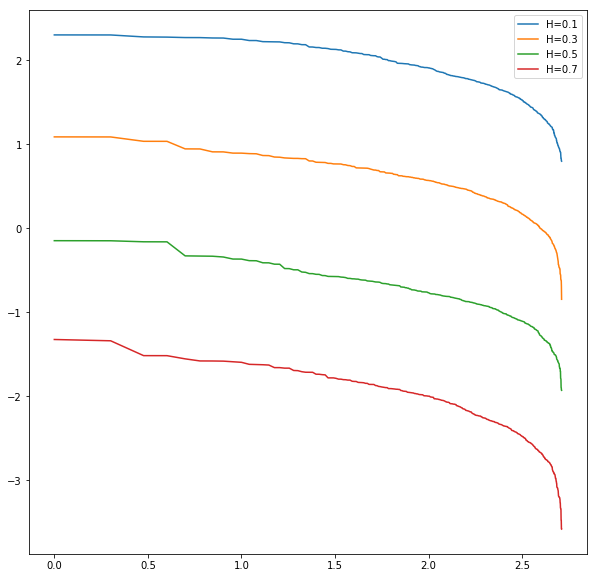

In [5]:
get_wavelet_var('haar',0.1)
get_wavelet_var('haar',0.3)
get_wavelet_var('haar',0.5)
get_wavelet_var('haar',0.7)

plt.legend(['H=0.1','H=0.3','H=0.5','H=0.7'])
plt.show()

#print(S)


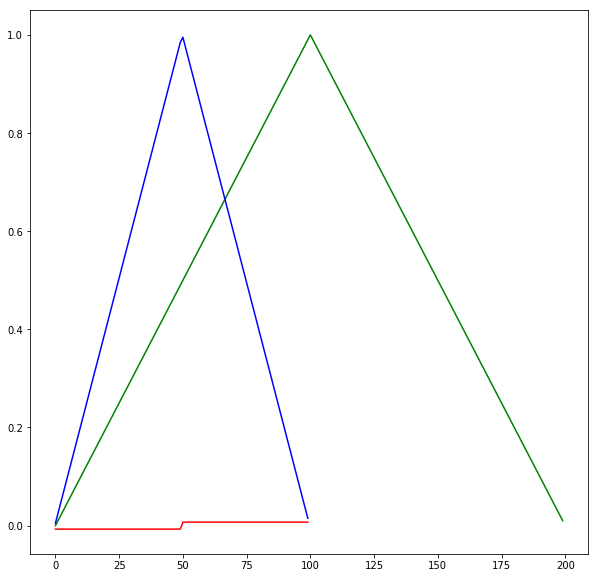

[-0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107 -0.00707107
 -0.00707107 -0.00707107  0.00707107  0.00707107  0.00707107  0.00707107
  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107
  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107
  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107
  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107  0.00707107
  0.00707107  0.00707107  0.00707107  0.00707107  0

In [6]:
tr_wave =np.zeros(200)
for i in range(200):
    tr_wave[i]= min(i,200-i)/100
tr_cA, tr_cD = pywt.dwt(tr_wave, 'haar')
plt.plot([i for i in range(len(tr_wave))], tr_wave,'g')
plt.plot([i for i in range(len(tr_cA))], tr_cA/1.414,'b')
plt.plot([i for i in range(len(tr_cD))], tr_cD,'r')
plt.show()
print(tr_cD)

1.02124403374


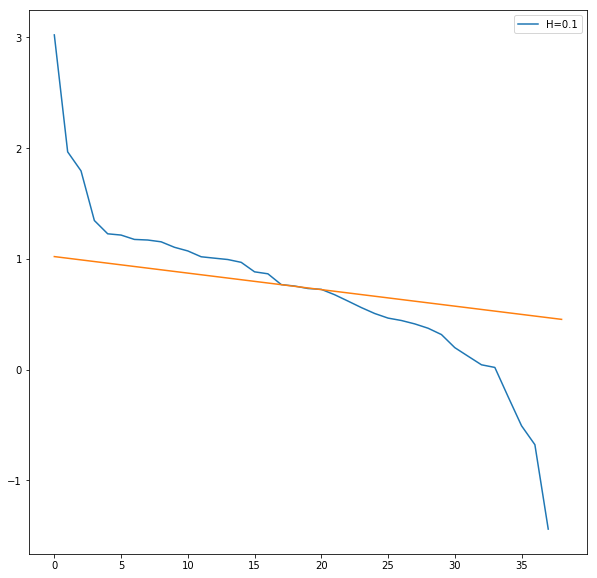

In [18]:
import pywt

def Lf(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

def Qf(x, A, B,C): # this is your 'straight line' y=f(x)
    return A*x**2 + B*x + C

def get_wavelet_var(wavelet,H=0.3,samp_size=150,est_sil=0,plot_sil=0):
    
    f = FBM(n=samp_size, hurst=H, length=0.5, method='daviesharte')
    # Generate a fBm realization
    fbm_sample = f.fbm()
    # Get the times associated with the fBm
    t_values = f.times()
    cA, cD = pywt.dwt(fbm_sample, wavelet)
    
    M=len(cD)
    #print(M)
    R=np.zeros(M+1) #Autocorrelation: r[0] to r[p-1]

    for k in range(M+1):
        cD_shift=shift(cD, k, cval=0)
        R[k]=np.sum(cD*np.conjugate(cD_shift))

    AutoCorr_mat=toeplitz(R[0:M],R[0:M])

    M=len(cD)//2
    #print(M)
    AutoCorr_mat_orig=np.zeros((M+1,M+1))
    for j in range(M+1):
        orig_seq=fbm_sample[j:M+j]
        for k in range(M+1):
            shift_seq=fbm_sample[k:M+k]
            AutoCorr_mat_orig[j][k]=np.sum(orig_seq*np.conjugate(shift_seq))
    
#     print(AutoCorr_mat_orig)
#     print(AutoCorr_mat)
#     print((np.log2(AutoCorr_mat_orig[0][0]/AutoCorr_mat[0][0])+1)/2)
    U,S,V=svd(AutoCorr_mat_orig)
    
    if(est_sil!=1):
        A,B = curve_fit(Lf,np.array([M//2-1,M//2,M//2+1])\
                        ,np.log10(S[M//2-1:M//2+2]))[0] # your data x, y to fit
        #print(A,B)
    if(plot_sil!=1):
        ax.plot(np.arange(M)\
                ,np.log10(S[0:M]),label=str("H="+str(H)))
        if(est_sil!=1):
            plt.plot([0,M],[B,A*(M)+B])
            
    if(est_sil!=1):
        print(B)
        return B

plt.rcParams['figure.figsize'] = (10, 10)
fig = plt.figure()
ax= fig.add_subplot(111)
get_wavelet_var('haar',0.1)
# get_wavelet_var('haar',0.3,plot_sil=0)
# get_wavelet_var('haar',0.5,plot_sil=0)
# get_wavelet_var('haar',0.7,plot_sil=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()

1.46050425197
1.97592277147
1.69582769213
1.51333502447


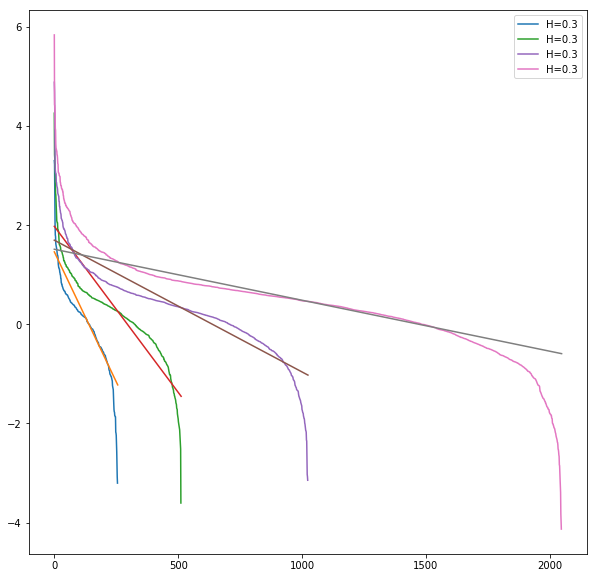

In [19]:
plt.rcParams['figure.figsize'] = (10, 10)
fig = plt.figure()
ax= fig.add_subplot(111)
get_wavelet_var('haar',0.3,1024,est_sil=0,plot_sil=0)
get_wavelet_var('haar',0.3,2048,est_sil=0,plot_sil=0)
get_wavelet_var('haar',0.3,4096,est_sil=0,plot_sil=0)
get_wavelet_var('haar',0.3,8192,est_sil=0,plot_sil=0)
#get_wavelet_var('haar',0.3,16384,est_sil=0,plot_sil=0)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()

24
0.958124644575
24
0.963253951385
24
0.776120432921
24
0.99807077648
24
0.89320695002
24
0.846553383661
24
0.890823012022
24
0.840061588411
24
0.844467464803
24
0.671237201419
24
0.814375931188
24
0.774396729989
24
0.535153613559
24
0.765203290891
24
0.622554447595
24
0.775976486201
24
0.614213698344
24
0.583734209848
24
0.492275468751
24
0.400728080673
24
0.318030822863
24
0.47814294132
24
0.31190256793
24
0.401315950787
24
0.324380014448
24
0.323960518562
24
-0.107758331271
24
-0.006645036133
24
0.00764925465591
24
0.022520624135
24
0.142567475692
24
-0.158647587013
24
-0.102161620787
24
-0.293821061944
24
-0.158633795401
24
-0.125046064373
24
-0.039179442587
24
-0.282996560937
24
-0.438924376057
24
-0.302639886719
24
-0.200900571599
24
-0.495864146777
24
-0.56064574849
24
-0.359118703549
24
-0.548126351767
24
-0.431171842834
24
-0.495196839564
24
-0.605433524455
24
-0.561321554096
24
-0.544623827533
24
-0.587760710371
24
-0.797522180224
24
-0.384869665517
24
-0.861388392082
24
-0.

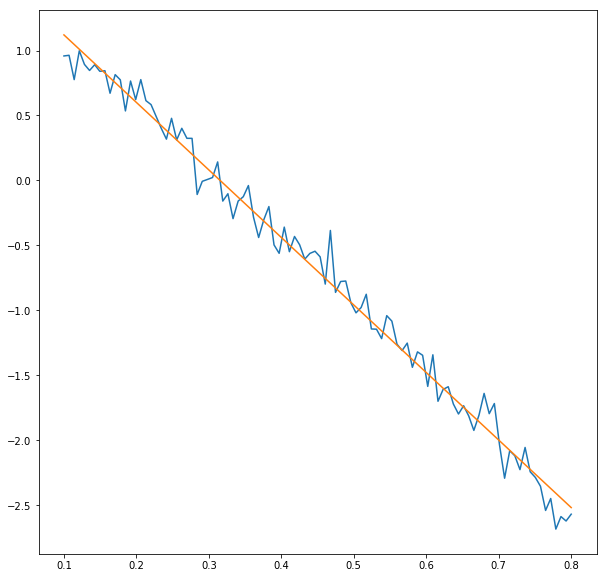

In [9]:
H_list=np.linspace(0.1,0.8,100)
intercept_vs_H=[get_wavelet_var('haar',H,150,est_sil=0,plot_sil=1) for H in H_list]
plt.rcParams['figure.figsize'] = (10, 10)
plt.plot(H_list,intercept_vs_H)
A,B = curve_fit(Lf,H_list,intercept_vs_H)[0] # your data x, y to fit
plt.plot([0.1,0.8],[A*(0.1)+B,A*(0.8)+B])
print(A,B)
plt.show()